## 生成 AI による記事分析/記事の改善案提案

ここでは、生成 AI　を活用してヒット記事を分析し、記事の改善案を提案する仕組みを作っていきます。

今回は、記事の原稿に対して、類似トピックのヒット記事を検索しそれらの記事がヒットした理由の分析から改善案を提案するというわかりやすい（＝説明性が高い）手法を採用します。

主に3つのステップで構築します。

1. ヒット記事の分析を行い保存する
2. 記事の embedding を作成し類似記事検索が行える DB を構築する
3. 原稿からヒットした類似記事を検索し分析から改善案を作成させる

## サンプルデータの用意

In [29]:
import pandas as pd
import os

output_path = "article_pv.csv"

if os.path.exists(output_path):
    result = pd.read_csv(output_path)

print(len(result))
result.head()

25520


,News ID,Category,Subcategory,Title,Abstract,URL,click
0,N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,1.0
1,N99744,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,8.0
2,N17957,health,weightloss,This Guy Altered His Diet and Training to Drop...,"Take Brandon Reid's advice: ""Don't worry what ...",https://assets.msn.com/labs/mind/AAGBR44.html,1.0
3,N13152,news,newsscienceandtechnology,"How to report weather-related closings, delays","When there are active closings, view them here...",https://assets.msn.com/labs/mind/AAlErhA.html,56.0
4,N22273,health,nutrition,"50 Foods You Should Never Eat, According to He...",This is so depressing.,https://assets.msn.com/labs/mind/AABDHTv.html,4.0


<AxesSubplot:xlabel='Category', ylabel='click'>

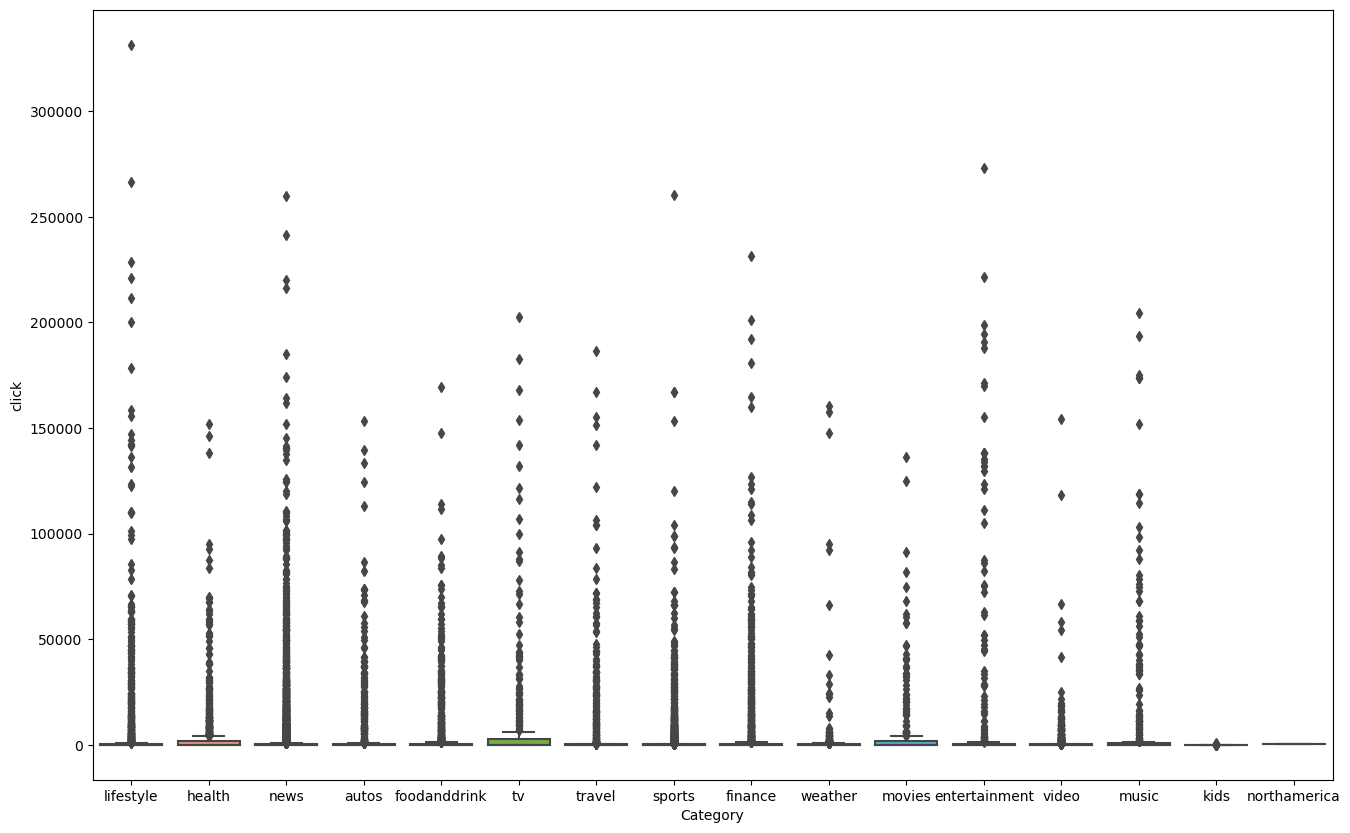

In [3]:
# カテゴリごとのPV数分布をプロット
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(x='Category', y='click', data=result)

## ヒット記事の分析

PV 数が15万以上のヒット記事に絞って分析していきます。

In [28]:
hits = result[result["click"] > 150000]
print(len(hits))
hits.head()

57


,News ID,Category,Subcategory,Title,Abstract,URL,click
16,N56873,tv,tv-gallery,Can you answer these real Jeopardy questions a...,"Culling data straight from the ""Jeopardy!"" arc...",https://assets.msn.com/labs/mind/AABs6Gq.html,167925.0
832,N65446,travel,traveltripideas,The most exclusive hotel in every state,All these hotels have just one thing in common...,https://assets.msn.com/labs/mind/AAJaLat.html,155006.0
970,N102458,lifestyle,shop-holidays,50 amazing gifts for every type of person and ...,Let the product experts at Reviewed help you f...,https://assets.msn.com/labs/mind/AAJQMdO.html,266407.0
3110,N17575,entertainment,entertainment-celebrity,Big celebrity money moments of the last decade,From bankruptcy filings and huge paydays to re...,https://assets.msn.com/labs/mind/AAJeXYC.html,198977.0
3165,N55792,entertainment,entertainment-celebrity,Stars Who Served in the Military,"Adam Driver, Jeff Bridges, Ice-T and more star...",https://assets.msn.com/labs/mind/AAJQC0V.html,194610.0


In [5]:
import boto3
import json

from enum import Enum, auto

class BaseModels(Enum):
    CLAUDE_21 = auto()
    CLAUDE_3_HAIKU = auto()
    CLAUDE_35_SONNET = auto()

# Ref: https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids-arns.html
model_to_id={}
model_to_id[BaseModels.CLAUDE_21] = "anthropic.claude-v2:1"
model_to_id[BaseModels.CLAUDE_3_HAIKU] = "anthropic.claude-3-haiku-20240307-v1:0"
model_to_id[BaseModels.CLAUDE_35_SONNET] = "anthropic.claude-3-5-sonnet-20240620-v1:0"

client = boto3.client("bedrock-runtime")

GENERATION_CONFIG = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 512,
    "temperature": 0.6,
    "top_k": 250,
    "top_p": 0.999,
    "stop_sequences": ["Human: ", "Assistant: "],
}


def _create_body(model: str, prompt: str):
    parameter = GENERATION_CONFIG
    parameter["messages"] = [{"role": "user", "content": prompt}]
    
    return json.dumps(parameter)


def invoke(prompt: str, model: BaseModels) -> str:
    payload = _create_body(model, prompt)

    model_id = model_to_id[model]
    accept = "application/json"
    content_type = "application/json"

    response = client.invoke_model(
        body=payload, modelId=model_id, accept=accept, contentType=content_type
    )

    output_txt = json.loads(response["body"].readlines()[0].decode('utf-8'))['content'][0]['text']

    return output_txt

Claude 3 Haiku を使用してヒット記事のヒット理由を分析させてみましょう。

まずはプロンプトの検証のために少量のデータで試してみます。

In [6]:
def analyze_article(title, abstract):
    prompt = f"""Human: 以下の article の PV が高い理由を分析しヒットを再現するためにはどうすれば良いか述べてください。
<article>
<title>{title}</title>
<absstract>{abstract}</abstract>
</article>
出力は <output></output> タグで囲み箇条書きで簡潔に書いてください。
<example-output>
- 著名人の不祥事という注目度の高い題材である。著名人の私生活や秘密に関する記事で再現可能。
</example-output>
Assistant: """
    return invoke(prompt, BaseModels.CLAUDE_3_HAIKU).replace("<output>", "").replace("</output>", "").strip()


for idx, row in hits[:2].iterrows():
    print(analyze_article(row["Title"], row["Abstract"]))
    print("")

- ジェパディのクイズ形式は人気があるため、ジェパディの実際のクイズを使った記事は注目を集めやすい
- テレビ番組に関するトリビアは、テレビファンにとって楽しい話題である
- 記事のタイトルがクイズ形式で、読者の知識を試すような仕掛けがある
- 記事の概要がさらにクイズを提示し、読者の興味を引き付ける
- 似たようなクイズ形式の記事や、テレビ番組のトリビアを使った記事を作成する

- タイトルに「最も」「全米No.1」といった強調表現を用い、読者の興味を引く
- 著名人が利用する高級ホテルという題材で、読者の夢と好奇心を刺激
- 各州の最高級ホテルという地域性を取り入れ、読者にとって身近な話題に
- 抽象的な説明ではなく、具体的なホテル名や料金を提示しリアリティを出す
- 画像や映像を多用し、読者がホテルの雰囲気を想像しやすくする



Claude 3 Haiku を使用することで記事のタイトルとあらすじからヒット記事の要素と再現する際のアイデアを得ることができました。

余裕があれば、上の`BaseModels.CLAUDE_3_HAIKU`を`BaseModels.CLAUDE_21`や`BaseModels.CLAUDE_35_SONNET`に変えてみて、モデルごとの出力結果の違いをチェックしてみてください。

続いてヒット記事全てに対して適用しデータを保存します

In [43]:
output_path = "analysis.csv"
if os.path.exists(output_path):
    hits = pd.read_csv(output_path)
    for idx, row in hits.iterrows():
        print(row["analysis"])
        print("")
else:
    analyses = []
    for idx, row in hits.iterrows():
        analysis = analyze_article(row["Title"], row["Abstract"])
        print(analysis)
        print("")
        analyses += [analysis]
    hits["analysis"] = analyses
    hits.to_csv(output_path, index=False)

- クイズ形式の記事は読者の知識を試す面白さがある
- テレビ番組に関するクイズは、多くの人が親しみを感じる題材
- ジェパディの実際の問題を使っていることで、クイズの難易度と面白さが保証される
- 記事タイトルがクイズ形式で、読者の興味を引く
- 記事の概要で、クイズの形式と内容が明確に説明されている
- 同じ形式と題材のクイズ記事を定期的に提供することで、読者を獲得できる

- タイトルに「最も」「全米No.1」といった強調表現を用い、読者の興味を引く
- 高級ホテルという非日常的な体験に対する人々の憧れをテーマにする
- セレブリティが訪れるホテルという著名人との接点をアピールする
- 掲載ホテルの写真を多用し、非日常的な雰囲気を伝える 
- SNSでのシェア数をアピールすることで話題性を高める

- 「あらゆるタイプの人」「あらゆる予算」というキーワードがあるので、多くの人に関心のある普遍的なテーマだと思われる。
- 「驚くべき」「完璧な」といった言葉でクリック率を高めている。
- 誕生日やクリスマスなどの贈り物選びのシーズンに合わせたタイミングの良い記事。
- Reviewedという信頼できる情報源からの贈り物のおすすめ記事。
- 具体的な商品のおすすめがあるため、実際に購入に結びつきやすい。

- セレブリティの金銭トラブルは注目を集める話題だ。セレブの破産や巨額の報酬、資産など金銭に関するゴシップ記事を作ることでPVを獲得できる。
- 過去10年間の出来事をまとめたリスト形式は読みやすくPVを集めやすい。時代背景を踏まえた10年間のトレンドを分析した記事を作れば再現できる。
- 著名人のスキャンダルやゴシップは関心が高く、クリック率が良い。セレブの金銭問題を扱った記事を作ればPVを獲得できる。

- 有名人の軍歴に関する記事であるため、有名人の過去の秘話や意外な一面に関心がある読者を引きつけている
- 具体的な有名人の名前が記載されているため、その有名人のファンも記事に興味を持つ
- 軍隊経験は一般人にはなじみが薄い世界なので、著名人のそうした経験に興味が惹かれる
- 同様の著名人の過去のエピソードや意外な経歴を扱った記事を制作することで、PVを再現できる可能性がある

- アメリカの上院議員に関する記事であるため、アメリカの政治に関心のある読者を引き

## Embedding を使用した類似ドキュメント検索の構築

記事の embedding を作成し類似記事検索が行える DB を構築します。

今回は検証用にローカルで FAISS インデックスを作成します。

継続的にデータを読み書きしてインデックスを更新するようなシステムとして構築する際は OpenSearch (Serverless) のベクトル検索機能や Aurora PostgreSQL  (Serverless v2) の pgvector 機能などを利用することも可能です。

OpenSearch を使用した例は[こちら](https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/03_QuestionAnswering/02_qa_w_rag_claude_opensearch.ipynb)。

In [44]:
!pip install "langchain==0.0.309" -qU
!pip install "SQLAlchemy==2.0.1" "typing_extensions==4.7.1" -qU
!pip install faiss-cpu -qU

# for gpu
# !pip install faiss-gpu -qU

In [45]:
from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock
from langchain.chains.question_answering import load_qa_chain
from langchain.vectorstores import FAISS
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.document_loaders import DataFrameLoader
import numpy as np

# 記事データのドキュメントを作成
hits["content"] = hits["Title"] + "\n" + hits["Abstract"]
loader = DataFrameLoader(hits, page_content_column="content")
docs = loader.load()

# Embedding 用モデル
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=client)

# ベクトルストア
vectorstore_faiss = FAISS.from_documents(
    docs,
    bedrock_embeddings,
)

wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss)

ベクトルストアが作成できたので検索をかけてみましょう。

関連のあるドキュメントが抽出できているのが確認できます。

In [61]:
def search(title, abstract):
    query = title + "\n" + abstract
    print("Title + Abstract: ", query)
    print("----")

    query_embedding = vectorstore_faiss.embedding_function(query)
    relevant_documents = vectorstore_faiss.similarity_search_by_vector(query_embedding)
    
    print(f'{len(relevant_documents)} documents are fetched which are relevant to the query.')
    print('----')
    for i, rel_doc in enumerate(relevant_documents):
        print(f'## Document {i+1}: {rel_doc.page_content}')
        print('---')
    
    return relevant_documents

In [66]:
low_view = result[result["click"] < 2]

doc_idx = low_view.index[2]
title, abstract = result["Title"][doc_idx], result["Abstract"][doc_idx]
relevant_documents = search(title, abstract)

Title + Abstract:  These Cranberry Sauce Recipes Are Perfect for Thanksgiving Dinner
You'll never want the store-bought version ever again.
----
4 documents are fetched which are relevant to the query.
----
## Document 1: 105 Black Friday Deals You Can Start Shopping Today
Save with early bird deals from stores like Walmart, Target, Amazon, Costco, Sam's Club, Kohl's, Sears, JCPenney, and Macy's, which are offering deep Black Friday discounts on the hottest products on your Christmas list   and your wish list   starting on Thanksgiving, or even sooner.
---
## Document 2: 65 Best Fall Soups That Will Warm You and Your Family Up All Season Long
These hearty bowls are the perfect companion for a rainy fall night.
---
## Document 3: Chrissy Teigen's weekend was basically a clapback double-header, plus more news
Chrissy Teigen gives us two more lessons in the art of the clapback. Plus, more celebrity news for Nov. 12, 2019.
---
## Document 4: See what your favorite stars look like without m

## RAG を活用した記事の改善案提案

最後に、構築したベクトルデータベースから検索した類似したトピックのヒット記事のエッセンスを活用して記事原稿を評価し改善案を提案してみましょう。

In [71]:
def evaluate_article(title, abstract, analysis):
    prompt = f"""Human: 過去の記事において PV 数が多い記事の要素も参照にしながら、
以下のトピックの PV 数の予測を10段階評価で答えてください。 
<PV 数の多い記事の要素>
{analysis}
</PV 数の多い記事の要素>
<トピック>
{title}
{abstract}
<トピック>
Assistant: """
    return invoke(prompt, "claude-v2").replace("<output>", "").replace("</output>", "").strip()


def improve_article(title, abstract, analysis):
    prompt = f"""Human: 過去の記事において PV 数が多い記事の要素も参考にしながら、
以下のトピックの PV 数を最大化するためにどのような切り口で報道するのが良いか？ そのためにどのような情報を収集すればいいか？
<PV 数の多い記事の要素>
{analysis}
<PV 数の多い記事の要素>
<トピック>
{title}
{abstract}
</トピック>
Assistant: """
    return invoke(prompt, "claude-v2").replace("<output>", "").replace("</output>", "").strip()

In [72]:
analysis = "\n".join([rel_doc.metadata["analysis"] for rel_doc in relevant_documents])

print(analysis)
print("---")
print(evaluate_article(title, abstract, analysis))
print("---")
print(improve_article(title, abstract, analysis))

- ブラックフライデーという人気のセールイベントをテーマにしている
- 有名ブランドのセール情報を具体的に提示している
- クリスマスプレゼントや欲しい商品のセールを強調している
- セールの開始時期を早期に知らせている
- 季節の変わり目というタイムリーな題材を扱っている
- 家族向けの温かい料理という生活に密着した内容
- 秋の味覚を使ったレシピという実用性が高い
- 65種類というレシピのボリュームがあり、選択肢が豊富
- 秋の季節感を掴んだ見出しと写真を使う
- SNSでシェアしやすい実用的な記事形式
- Chrissy Teigenの名前がタイトルにある。有名人の名前をタイトルに使うと注目を集める。
- "clapback"というキーワードがタイトルと概要にある。SNSでのやり取りや反応に関する記事は注目される。
- "celebrity news"という人気の高いジャンルだ。最新の有名人ニュースを扱った記事で再現できる。
- 短い概要文で記事の内容を示唆する形式。同じ形式の記事で再現可能。
- 著名人の素顔やプライベートな姿に関する記事は注目度が高いため、同様のコンテンツを作ることでPVを獲得できる。
- タイトルに「お気に入りのスターの素顔」というキーワードを使うことで、読者の興味を引くことができる。
- 記事本文では多くの著名人のメイクなしの写真を掲載することが重要。
- SNSでの著名人の素顔自撮りなどの話題を取り上げることも効果的。
- 著名人のプライベートな一面をのぞかせる記事は人気があるので、同様のアプローチが再現の鍵。
---
この記事のトピックは「サンクスギビングのディナーにぴったりなクランベリーソースのレシピ」です。
PV数の予測を10段階で評価すると、この記事の特徴から6点を付けたいと思います。

この記事はサンクスギビングという人気の祝日をテーマにした、実用的な料理レシピ記事です。 
季節の変わり目というタイムリーな題材を扱っている点はPV獲得に有利です。
また、家族向けの温かい料理という生活に密着した内容で、実用性も高いでしょう。

一方で、具体的なレシピの数が明記されていない、有名人や話題性のあるキーワードが含まれていないなど、
さらなるPVを獲得するための要素が不足していると感じます。

全体として、季節に合った実用的な料理レ